## Predicción de Precios de Vehículos Usados (Core)

### Requisitos:

 1. Carga y Exploración de Datos:

- Descargar y cargar el dataset.
- Realizar una exploración inicial para entender la estructura del dataset.
- Identificar valores faltantes, duplicados y outliers.



In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.datasets import fetch_openml
from sklearn.metrics import accuracy_score, mean_squared_error, r2_score, mean_absolute_error, classification_report, confusion_matrix
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
import lightgbm as lgb

In [2]:
#cargamos el dataset
df = pd.read_csv('C:/Users/diego/Documents/repositorios/vehicles/vehicles.csv')

In [3]:
#realizamos la exploracion inicial para entender la estructura del dataset
print(df.shape)
df.info()
df.head()

(426880, 26)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 426880 entries, 0 to 426879
Data columns (total 26 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            426880 non-null  int64  
 1   url           426880 non-null  object 
 2   region        426880 non-null  object 
 3   region_url    426880 non-null  object 
 4   price         426880 non-null  int64  
 5   year          425675 non-null  float64
 6   manufacturer  409234 non-null  object 
 7   model         421603 non-null  object 
 8   condition     252776 non-null  object 
 9   cylinders     249202 non-null  object 
 10  fuel          423867 non-null  object 
 11  odometer      422480 non-null  float64
 12  title_status  418638 non-null  object 
 13  transmission  424324 non-null  object 
 14  VIN           265838 non-null  object 
 15  drive         296313 non-null  object 
 16  size          120519 non-null  object 
 17  type          334022 non-null  obje

,id,url,region,region_url,price,year,manufacturer,model,condition,cylinders,...,size,type,paint_color,image_url,description,county,state,lat,long,posting_date
0,7222695916,https://prescott.craigslist.org/cto/d/prescott...,prescott,https://prescott.craigslist.org,6000,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,az,NaN,NaN,NaN
1,7218891961,https://fayar.craigslist.org/ctd/d/bentonville...,fayetteville,https://fayar.craigslist.org,11900,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,ar,NaN,NaN,NaN
2,7221797935,https://keys.craigslist.org/cto/d/summerland-k...,florida keys,https://keys.craigslist.org,21000,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,fl,NaN,NaN,NaN
3,7222270760,https://worcester.craigslist.org/cto/d/west-br...,worcester / central MA,https://worcester.craigslist.org,1500,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,ma,NaN,NaN,NaN
4,7210384030,https://greensboro.craigslist.org/cto/d/trinit...,greensboro,https://greensboro.craigslist.org,4900,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,nc,NaN,NaN,NaN


In [4]:
# Identificación de valores duplicados
duplicados = df.duplicated().sum()
print(f'Número de registros duplicados: {duplicados}')

# Eliminación de valores duplicados
#df_train = df.drop_duplicates()

Número de registros duplicados: 0


In [5]:
#Calculamos los valores nulos 
#Codigo Hecho por el profesor Iair Linker
def calculate_na_statistics(df: pd.DataFrame):
    qsna = df.shape[0] - df.isnull().sum(axis=0)
    qna = df.isnull().sum(axis=0)
    ppna = np.round(100 * (df.isnull().sum(axis=0) / df.shape[0]), 2)
    aux = {'datos sin NAs en q': qsna, 'Na en q': qna, 'Na en %': ppna}
    na = pd.DataFrame(data=aux)
    return na.sort_values(by='Na en %', ascending=False)

null_values = calculate_na_statistics(df)
null_values

,datos sin NAs en q,Na en q,Na en %
county,0,426880,100.00
size,120519,306361,71.77
cylinders,249202,177678,41.62
condition,252776,174104,40.79
VIN,265838,161042,37.73
drive,296313,130567,30.59
paint_color,296677,130203,30.50
type,334022,92858,21.75
manufacturer,409234,17646,4.13
title_status,418638,8242,1.93


In [6]:
#mostrar las columnas con valores nulos
nulos = null_values[null_values['Na en %'] >20]
nulos

,datos sin NAs en q,Na en q,Na en %
county,0,426880,100.00
size,120519,306361,71.77
cylinders,249202,177678,41.62
condition,252776,174104,40.79
VIN,265838,161042,37.73
drive,296313,130567,30.59
paint_color,296677,130203,30.50
type,334022,92858,21.75


In [7]:
#Ver las columnas con el tipo de dato que tienen los valores nulos
null_types = df.dtypes[nulos.index]
null_types

county         float64
size            object
cylinders       object
condition       object
VIN             object
drive           object
paint_color     object
type            object
dtype: object

In [8]:
numerical_columns = df.select_dtypes(include=[np.number]).columns
numerical_columns

Index(['id', 'price', 'year', 'odometer', 'county', 'lat', 'long'], dtype='object')

In [9]:
#Codigo para detectar outliers usando el IQR
def detect_outliers_iqr(data):
    Q1 = data.quantile(0.25)
    Q3 = data.quantile(0.75)
    IQR = Q3 - Q1
    # Define bounds
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    # Return True for outliers
    return (data < lower_bound) | (data > upper_bound)

In [10]:
# Create a summary DataFrame for outliers
outliers_summary = pd.DataFrame()
for column in numerical_columns:
    outliers = detect_outliers_iqr(df[column])
    outliers_summary[column] = {
        'Number of Outliers': outliers.sum(),
        'Percentage of Outliers': 100 * outliers.mean(),
        'Lower Bound': df[column][~outliers].min(),
        'Upper Bound': df[column][~outliers].max()
    }

# Save the summary to a CSV file
outliers_summary.T

,Number of Outliers,Percentage of Outliers,Lower Bound,Upper Bound
id,44.0,0.010307,7.301583e+09,7.317101e+09
price,8177.0,1.915527,0.000000e+00,5.734100e+04
year,15896.0,3.723763,1.995000e+03,2.022000e+03
odometer,4385.0,1.027221,0.000000e+00,2.772310e+05
county,0.0,0.000000,NaN,NaN
lat,6413.0,1.502296,2.315896e+01,5.271683e+01
long,195.0,0.045680,-1.585996e+02,-3.945968e+01



 2. Limpieza y Preprocesamiento:

- Manejar valores faltantes.
- Eliminar duplicados.
- Corregir inconsistencias en los datos categóricos.
- Escalar las características numéricas.
- Realizar transformaciones necesarias para las características categóricas.


In [11]:
df.head(3).T

,0,1,2
id,7222695916,7218891961,7221797935
url,https://prescott.craigslist.org/cto/d/prescott...,https://fayar.craigslist.org/ctd/d/bentonville...,https://keys.craigslist.org/cto/d/summerland-k...
region,prescott,fayetteville,florida keys
region_url,https://prescott.craigslist.org,https://fayar.craigslist.org,https://keys.craigslist.org
price,6000,11900,21000
year,NaN,NaN,NaN
manufacturer,NaN,NaN,NaN
model,NaN,NaN,NaN
condition,NaN,NaN,NaN
cylinders,NaN,NaN,NaN


In [12]:
drop_columns = ['id', 'url', 'region', 'region_url','model', 'title_status', 'VIN', 'size','description', 'image_url', 'lat','long','posting_date', 'county', 'state']
train = df.drop(columns = drop_columns)

In [13]:
train.info()
train_nulls= calculate_na_statistics(train)
new_nulls = train_nulls[train_nulls['Na en %'] >20]
new_nulls

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 426880 entries, 0 to 426879
Data columns (total 11 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   price         426880 non-null  int64  
 1   year          425675 non-null  float64
 2   manufacturer  409234 non-null  object 
 3   condition     252776 non-null  object 
 4   cylinders     249202 non-null  object 
 5   fuel          423867 non-null  object 
 6   odometer      422480 non-null  float64
 7   transmission  424324 non-null  object 
 8   drive         296313 non-null  object 
 9   type          334022 non-null  object 
 10  paint_color   296677 non-null  object 
dtypes: float64(2), int64(1), object(8)
memory usage: 35.8+ MB


,datos sin NAs en q,Na en q,Na en %
cylinders,249202,177678,41.62
condition,252776,174104,40.79
drive,296313,130567,30.59
paint_color,296677,130203,30.50
type,334022,92858,21.75


In [14]:
# Identificar las columnas con más del 20% de valores nulos 
columns_to_dropna = new_nulls.index.tolist() 
# Eliminar filas con valores nulos en esas columnas
train1 = train.dropna(subset=columns_to_dropna)
# Verificación
print(f'Número de filas antes de la eliminación: {train.shape[0]}')
print(f'Número de filas después de la eliminación: {train1.shape[0]}')

Número de filas antes de la eliminación: 426880
Número de filas después de la eliminación: 123149


In [15]:
# Asegurarse de que 'train1' es un DataFrame
if isinstance(train1, pd.Series):
    train2= train1.to_frame()

# Transformar las columnas de tipo 'object' a 'category'
train2 = train1.apply(lambda col: col.astype('category') if col.dtype == 'object' else col)


# Manejo de valores NaN reemplazándolos en las columnas numéricas
train2_numeric = train2.select_dtypes(include=['float64', 'int64'])
train2[train2_numeric.columns] = train2_numeric.fillna(0)

# Conversión de columnas de float64 a int64 
train2 = train2.apply(lambda col: np.round(col).astype('int64') if col.dtype == 'float64' else col)

# Verificación de los tipos de datos 
print(train2.dtypes)

price              int64
year               int64
manufacturer    category
condition       category
cylinders       category
fuel            category
odometer           int64
transmission    category
drive           category
type            category
paint_color     category
dtype: object


In [16]:
# Function to detect outliers using IQR
def detect_outliers_iqr(data):
    Q1 = data.quantile(0.25)
    Q3 = data.quantile(0.75)
    IQR = Q3 - Q1
    # Define bounds
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    # Return True for outliers
    return (data < lower_bound) | (data > upper_bound)

In [17]:
# Identify numerical columns
numerical_columns = train2.select_dtypes(include=[np.number]).columns
# Create a summary DataFrame for outliers
outliers_summary = pd.DataFrame()
for column in numerical_columns:
    outliers = detect_outliers_iqr(train2[column])
    outliers_summary[column] = {
        'Number of Outliers': outliers.sum(),
        'Percentage of Outliers': 100 * outliers.mean(),
        'Lower Bound': train2[column][~outliers].min(),
        'Upper Bound': train2[column][~outliers].max()
    }

# Save the summary to a CSV file
outliers_summary.T

,Number of Outliers,Percentage of Outliers,Lower Bound,Upper Bound
price,2403.0,1.951295,0.0,49000.0
year,6219.0,5.049980,1993.0,2022.0
odometer,1299.0,1.054820,0.0,287468.0


In [ ]:
# Comparamos  con  los outliers
train2.describe().T

,count,mean,std,min,25%,50%,75%,max
price,123149.0,58718.116802,1.112765e+07,0.0,5500.0,10990.0,22900.0,3.736929e+09
year,123149.0,2009.061982,1.049994e+01,1900.0,2006.0,2012.0,2015.0,2.022000e+03
odometer,123149.0,112248.401733,2.297049e+05,0.0,54000.0,101928.0,147509.0,1.000000e+07


_Aca podemos ver que el **lower bound** de precios y odometer coincide con el **min** de describe, pero no el de year, por eso verificamos el dataset antes de 1993_

(6219, 11)
count    6219.000000
mean     1973.844670
std        15.500941
min      1900.000000
25%      1966.000000
50%      1977.000000
75%      1987.000000
max      1992.000000
Name: year, dtype: float64


array([[<Axes: title={'center': 'year'}>]], dtype=object)

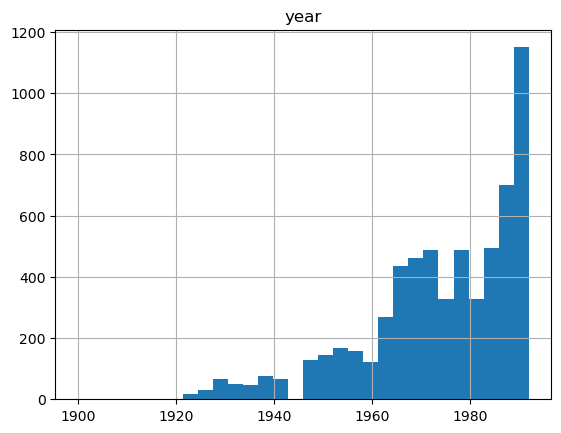

In [19]:
# create a dataframe where year is less the 1993
filtro_year = train2[train2['year'] < 1993]
print(filtro_year.shape)
print(filtro_year['year'].describe())
filtro_year.hist(column='year', bins=30)

_Vemos que comenzando 1960 recien tenemos mas de 200 vehiculos_

(122105, 11)
count    122105.000000
mean       2009.595709
std           8.751823
min        1961.000000
25%        2006.000000
50%        2012.000000
75%        2015.000000
max        2022.000000
Name: year, dtype: float64


array([[<Axes: title={'center': 'year'}>]], dtype=object)

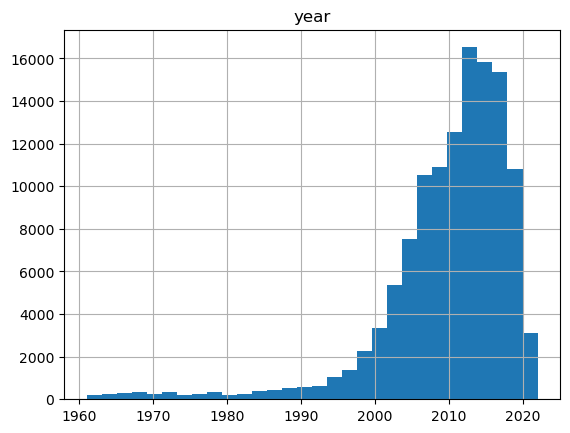

In [20]:
filtro_year2 = train2[train2['year'] > 1960]
print(filtro_year2.shape)
print(filtro_year2['year'].describe())
filtro_year2.hist(column='year', bins=30)

_Tambien vemos un filtro para price entre 1000 y 70000_

(114987, 11)
count    114987.000000
mean      16104.167697
std       12531.316495
min        1012.000000
25%        6495.000000
50%       11950.000000
75%       23900.000000
max       69999.000000
Name: price, dtype: float64


array([[<Axes: title={'center': 'price'}>]], dtype=object)

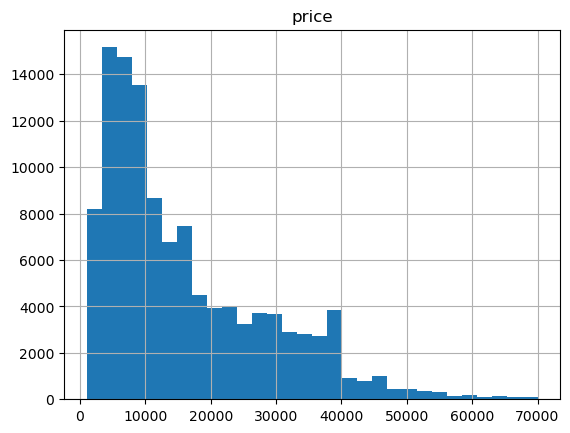

In [21]:
# create a dataframe where price its greater then 1000 and less then 70000
filtro_price = train2[(train2['price'] > 1000) & (train2['price'] < 70000)]
print(filtro_price.shape)
print(filtro_price['price'].describe())
filtro_price.hist(column='price', bins=30)

_Encontramos que mas del 90% del dataset se encuentra dentro de este rango_

_Tambien creamos un filtro odometer buscando un rango donde tengamos la mayor parte del dataset_

(121384, 11)
count    121384.000000
mean     105227.931317
std       63028.270495
min           1.000000
25%       55500.000000
50%      102044.000000
75%      147000.000000
max      349525.000000
Name: odometer, dtype: float64


array([[<Axes: title={'center': 'odometer'}>]], dtype=object)

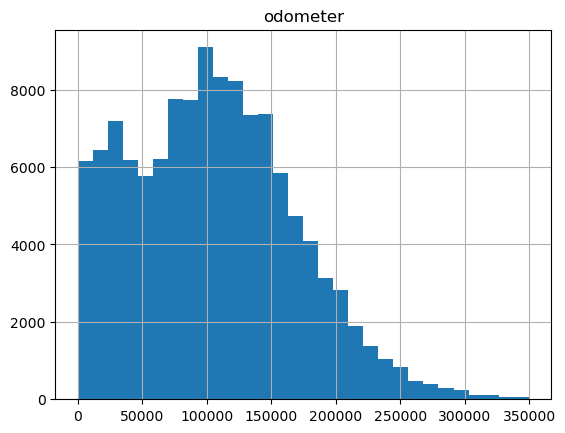

In [22]:
# create a dataframe where odometer its greater then 1 and less then 200000
filtro_odometer = train2[(train2['odometer'] > 0) & (train2['odometer'] < 350000)]
print(filtro_odometer.shape)
print(filtro_odometer['odometer'].describe())
filtro_odometer.hist(column='odometer', bins=30)


_En este rango podemos observar que se encuentra mas del 90% de los datos_

In [23]:
# Crear un dataframe filtrado con las condiciones anteriores
def apply_filters(row):
    return ( 
            row['year'] > 1960 and 
            1000 < row['price'] < 70000 and 
            0 < row['odometer'] < 350000 ) 

# Aplicar la función a cada fila del DataFrame 
train3 = train2[train2.apply(apply_filters, axis=1)]

_Encontramos que la mayor parte de este dataset se encuentra dentro del rango del 1 a 350000_

In [24]:
#definimos nuestros features y nuestro target
X = train3.drop('price', axis=1)
y = train3['price']

# Definir las características numéricas y categóricas
numeric_features = ['year', 'odometer']
categorical_features = ['manufacturer', 'condition', 'cylinders', 'fuel', 
                        'transmission', 'drive', 'type', 'paint_color']



_Aca ya definimos nuestro target y nuestros features, asi como nuestras variables que vamos a pasar para la transformacion_


 3. Exploración de Datos:

- Crear visualizaciones univariadas y multivariadas.
- Calcular estadísticas descriptivas.


<Figure size 1500x600 with 0 Axes>

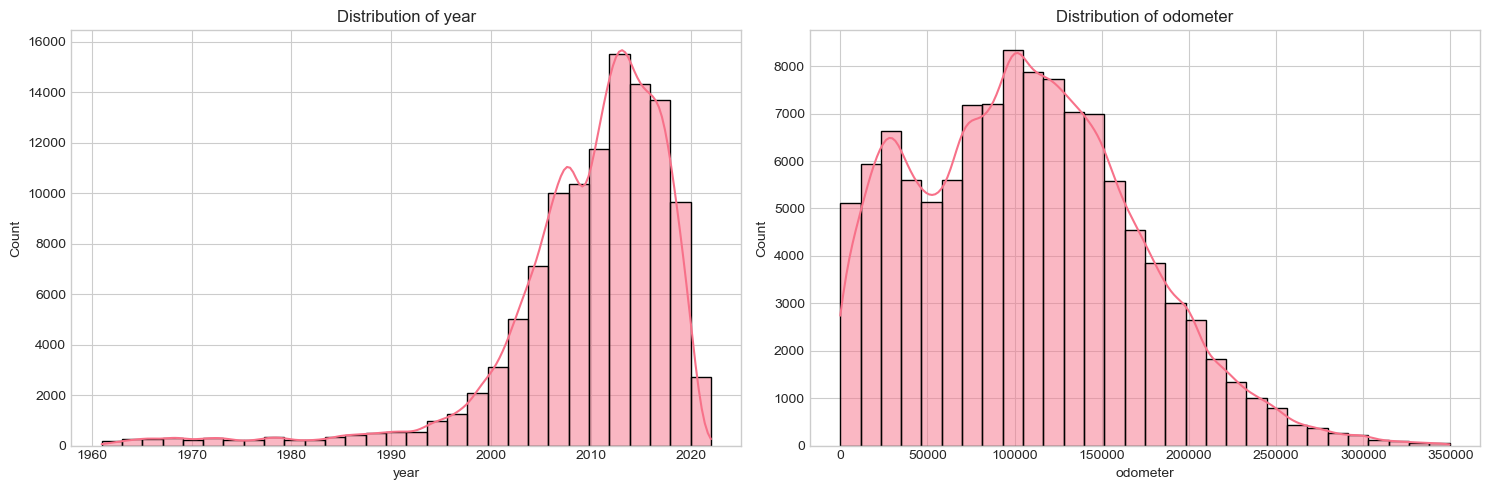

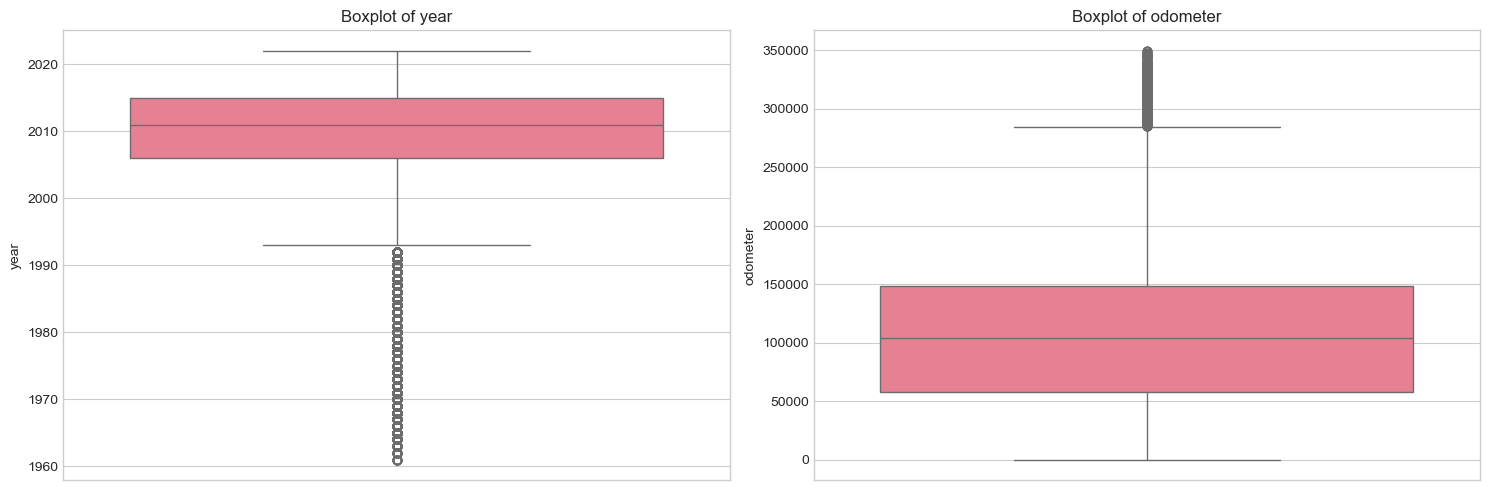

In [25]:
plt.style.use("seaborn-v0_8-whitegrid")
sns.set_palette("husl")
    
# Create figure for numeric features distribution
plt.figure(figsize=(15, 6))
    
    # Numeric features analysis
numeric_stats = X[numeric_features].describe()
    
    # Distribution plots for numeric features
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
for idx, feature in enumerate(numeric_features):
    sns.histplot(data=X, x=feature, bins=30, kde=True, ax=axes[idx])
    axes[idx].set_title(f'Distribution of {feature}')
    plt.tight_layout()
    
    # Boxplots for numeric features
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
for idx, feature in enumerate(numeric_features):
        sns.boxplot(data=X, y=feature, ax=axes[idx])
        axes[idx].set_title(f'Boxplot of {feature}')
plt.tight_layout()
    
    # Correlation with price for numeric features
correlations = {}
for feature in numeric_features:
        correlation = np.corrcoef(X[feature], y)[0, 1]
        correlations[feature] = correlation
    

_Vemos como como el histograma de year esta sesgado  a la izquierda y el boxplot nos muestra que nuestra media esta en 2011 aproximadamente_

_En odometer vemos un sesgo a la derecha y el boxplot nuestra la media cerca de los 100.000_

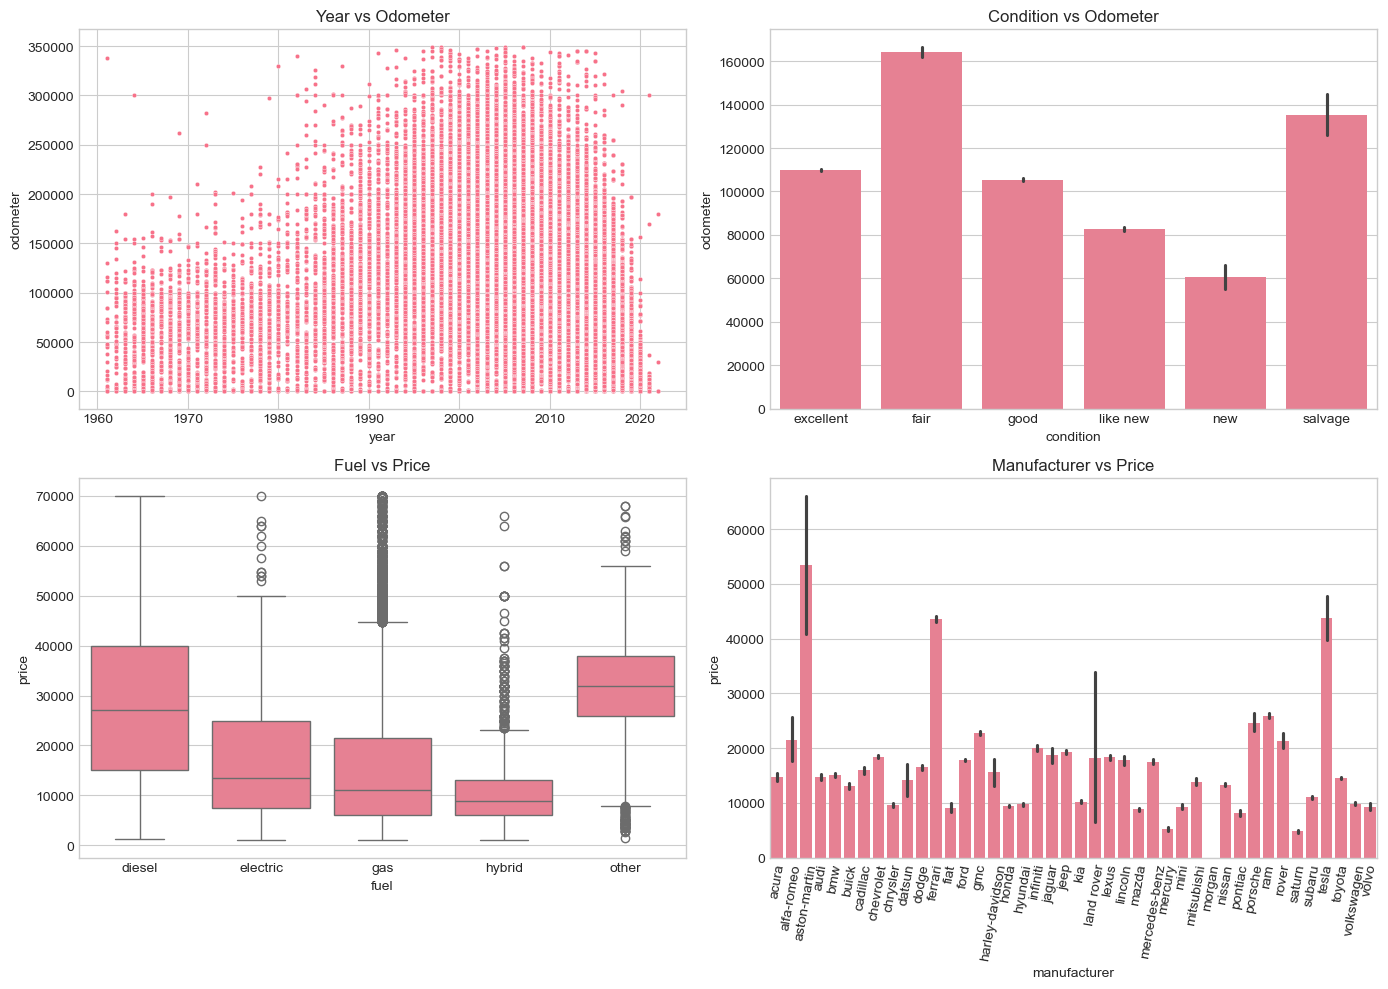

In [26]:
fig, axs = plt.subplots(2, 2, figsize=(14, 10))

# scatter plot for year and odometer
sns.scatterplot(data=train3, x = train3['year'], y = train3['odometer'], s=10, ax=axs[0, 0])
axs[0, 0].set_title("Year vs Odometer")

# barplot for condition and odometer
sns.barplot(data=train3, x = train3['condition'], y = train3['odometer'], ax=axs[0, 1])
axs[0, 1].set_title("Condition vs Odometer")

# boxplot fuel and price
sns.boxplot(data=train3, x = train3['fuel'], y = train3['price'], ax=axs[1, 0])
axs[1, 0].set_title("Fuel vs Price")

# histogram for manufacturer and price
sns.barplot(data=train3, x = train3['manufacturer'], y = train3['price'], ax=axs[1, 1])
plt.xticks(rotation=80) 
axs[1, 1].set_title("Manufacturer vs Price")

plt.tight_layout()
plt.show()

Year vs odometer : podemos ver que hay una mayor cantidad de vehiculos que alcanzan altos kilometrajes entre 1990 y 2000.

Condition vs odometer : podemos ver que la mayor diferencia esta en fair, los good y excelent son muy parecidos, new y like new eran predecibles.

Fuel vs price : podemos ver que los precios de vehiculos a diesel en promedio son mas  elevados, considerando que tenemos mas datos de vehiculos a gasolina, los other tenemos poca informacion.

Manufacturer vs price : Encontramos que dentro del rango que elegimos trabajar la marca con precio mas elevado es aston martin, seguido por tesla, y ferrari, despues no hay gran relevancia en los demas precios.

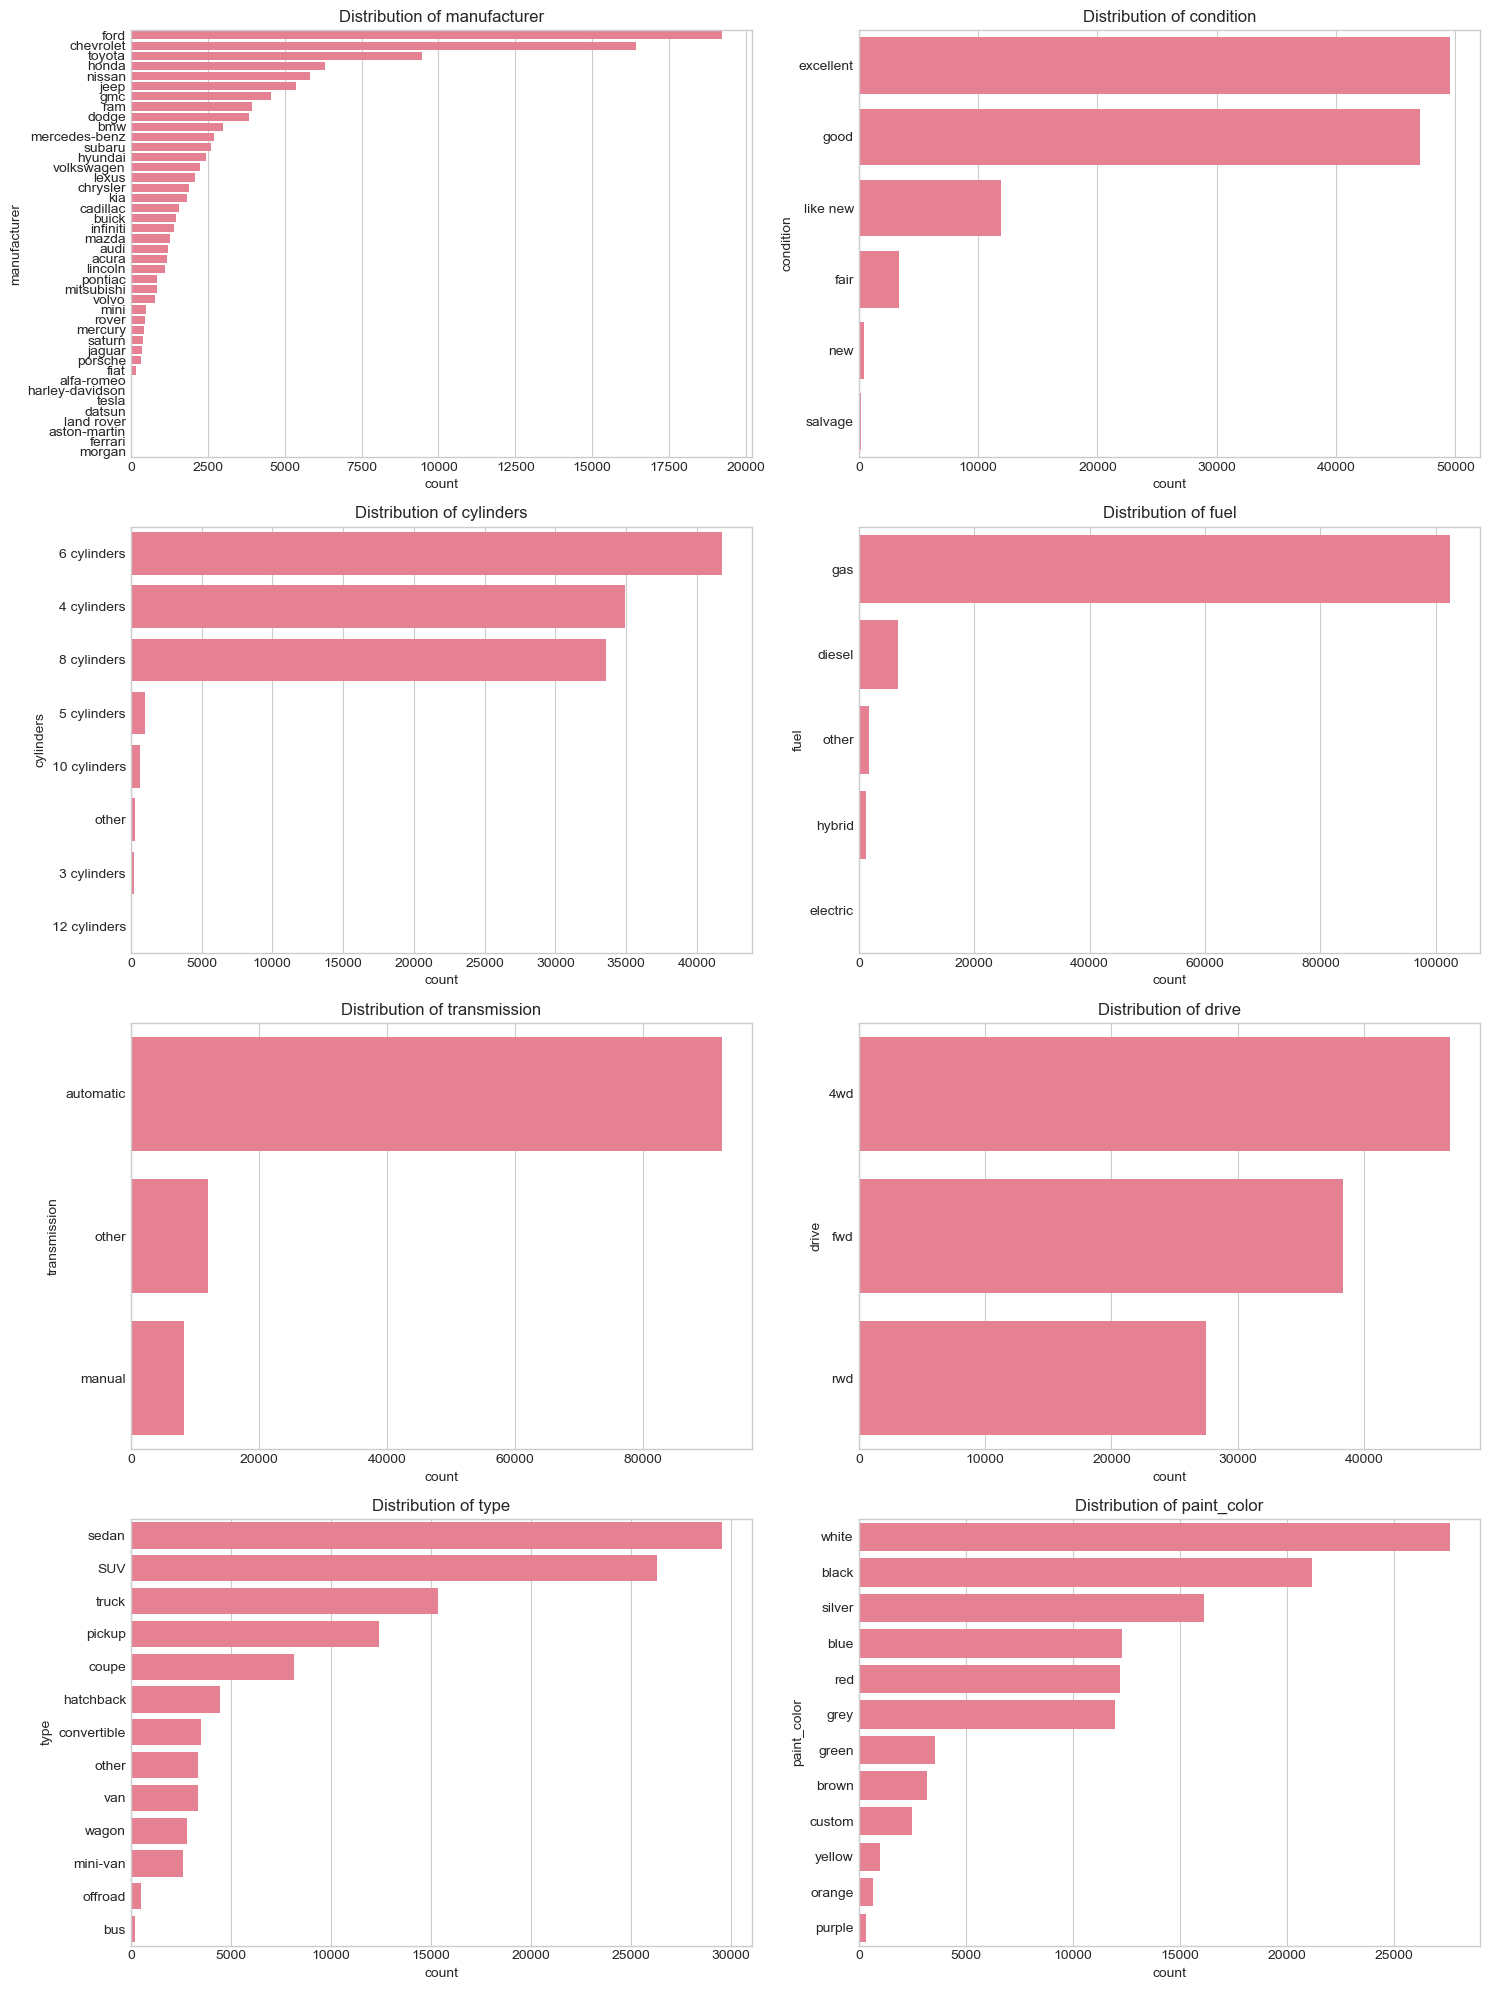

In [ ]:
    # Categorical features analysis
categorical_stats = {feature: X[feature].value_counts() for feature in categorical_features}
    
    # Bar plots for categorical features
num_cols = 2
num_rows = (len(categorical_features) + num_cols - 1) // num_cols
fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 5*num_rows))
axes = axes.ravel()
    
for idx, feature in enumerate(categorical_features):
    sns.countplot(data=X, y=feature, ax=axes[idx], order=X[feature].value_counts().index)
    axes[idx].set_title(f'Distribution of {feature}')
    
    # Remove empty subplots if any
if len(categorical_features) % num_cols != 0:
    for idx in range(len(categorical_features), len(axes)):
        fig.delaxes(axes[idx])
    
plt.tight_layout()
    

Manufacturer: Ford y Chevrolet dominan el mercado, con el resto de fabricantes significativamente menos representados.

Condition: La mayoría de los vehículos están clasificados como "good" o "excellent".

Cylinders: Los vehículos con 6, 4 y 8 cilindros son los más comunes.

Fuel: El combustible más utilizado es la gasolina, seguido por el diésel.

Transmission: Las transmisiones automáticas predominan ampliamente sobre las manuales.

Drive: La mayoría de los vehículos tienen tracción trasera (rwd) o tracción total (4wd).

Type: Los sedanes, SUVs y camionetas (trucks) son los tipos más comunes.

Paint Color: Los colores más populares son el blanco, negro y plateado, mientras que los colores personalizados son menos comunes.

Correlation between price and numeric features:
year: 0.41548492277167604
odometer: -0.5674659067336285
                year       odometer          price
count  112631.000000  112631.000000  112631.000000
mean     2009.501896  106702.438973   16093.807744
std         8.710908   62797.399291   12530.796010
min      1961.000000       1.000000    1012.000000
25%      2006.000000   57618.500000    6495.000000
50%      2011.000000  104000.000000   11915.000000
75%      2015.000000  148569.000000   23901.000000
max      2022.000000  349525.000000   69999.000000


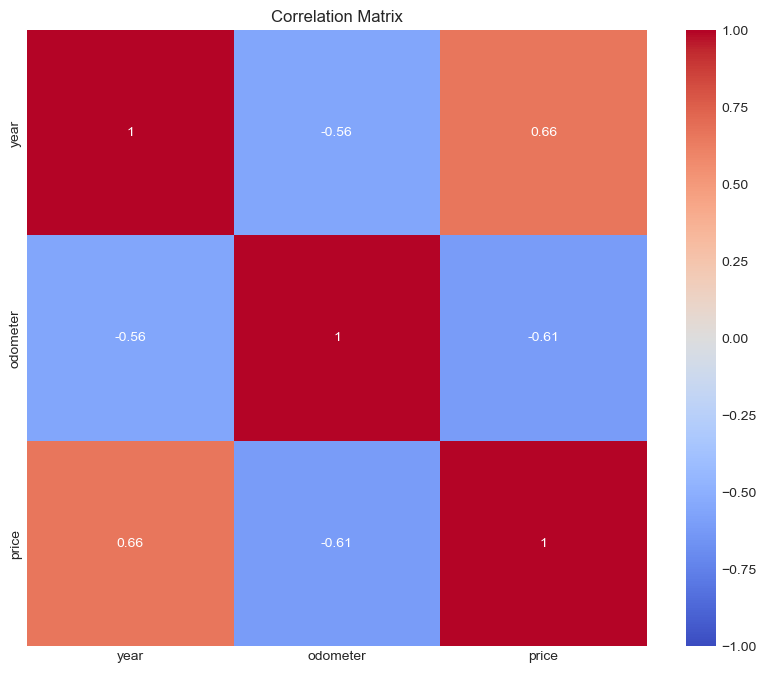

In [33]:
# Correlation with price for numeric features
correlations = {}
for feature in numeric_features:
    correlation = np.corrcoef(X[feature], y)[0, 1]
    correlations[feature] = correlation



# print correlation results
print("Correlation between price and numeric features:")
for feature, correlation in correlations.items():
    print(f"{feature}: {correlation}")

numerical_features = ['year', 'odometer','price']
print(train3[numerical_features].describe())

# calculate correlation with numerical_features
corr_matrix = train3[numerical_features].corr(method='spearman')

# create a heatmap of the correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title("Correlation Matrix")
plt.show()

Year vs. Price (0.66): Hay una correlación positiva moderada; los vehículos más nuevos tienden a tener precios más altos.

Odometer vs. Price (-0.61): Correlación negativa moderada; mayor kilometraje suele asociarse con precios más bajos.


 1. Modelado y Evaluación:

- Implementar al menos dos modelos de regresión (Linear Regression y Random Forest Regressor).
- Evaluar los modelos utilizando MSE, RMSE, y R^2.
- Seleccionar el mejor modelo basado en las métricas de evaluación.


In [29]:
# Pipeline para datos numéricos
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value=0)),   # Imputación
    ('scaler', StandardScaler())                  # Escalado
])

# Pipeline para datos categóricos
categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))    # One-hot encoding
])

#preparamos nuestro dataset para entrenar y testear
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


# Combinación de transformadores
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),    # Transformador numérico
        ('cat', categorical_transformer, categorical_features) # Transformador categórico
    ]
)

# Preprocesar los datos de entrenamiento y prueba
X_train_imputed = preprocessor.fit_transform(X_train)
X_test_imputed = preprocessor.transform(X_test)
# Crear y entrenar los modelos 

# Modelo de Regresión Lineal 
modelo_regresion = LinearRegression() 
modelo_regresion.fit(X_train_imputed, y_train) 
y_pred_regresion = modelo_regresion.predict(X_test_imputed) 

# Modelo Random Forest Regressor
modelo_rf = RandomForestRegressor(n_estimators=10, random_state=42)
modelo_rf.fit(X_train_imputed, y_train)
y_pred_rf = modelo_rf.predict(X_test_imputed) 


Resultados en el conjunto de prueba - Regresión Lineal:
Error Cuadrático Medio (MSE): 47735066.09
Coeficiente de Determinación (R²): 0.70
Error Absoluto Medio (MAE): 4833.86



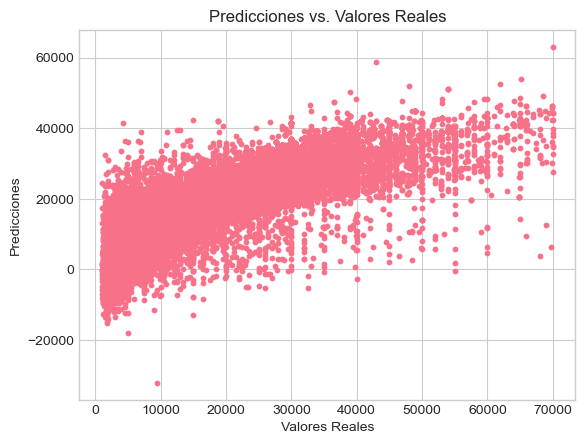

In [30]:

# Métricas para Regresion lineal
mae_regresion = mean_absolute_error(y_test, y_pred_regresion)
mse_regresion = mean_squared_error(y_test, y_pred_regresion)
r2_regresion = r2_score(y_test, y_pred_regresion) 
print("Resultados en el conjunto de prueba - Regresión Lineal:") 
print(f"Error Cuadrático Medio (MSE): {mse_regresion:.2f}") 
print(f"Coeficiente de Determinación (R²): {r2_regresion:.2f}") 
print(f"Error Absoluto Medio (MAE): {mae_regresion:.2f}\n") 


# Gráfico de dispersión de las predicciones vs. valores reales
plt.scatter(y_test, y_pred_regresion, s=10)
plt.xlabel('Valores Reales')
plt.ylabel('Predicciones')
plt.title('Predicciones vs. Valores Reales')
plt.show()


**Conclusión**:
El gráfico y las métricas muestran que el modelo de regresión lineal tiene un rendimiento decente, con un R² de 0.70 indicando una buena explicación de la variabilidad de los datos. Los errores, aunque presentes, no son excesivamente altos.

Resultados en el conjunto de prueba - Random Forest Regressor:
Error Cuadrático Medio (MSE): 16512704.31
Coeficiente de Determinación (R²): 0.90
Error Absoluto Medio (MAE): 2116.46



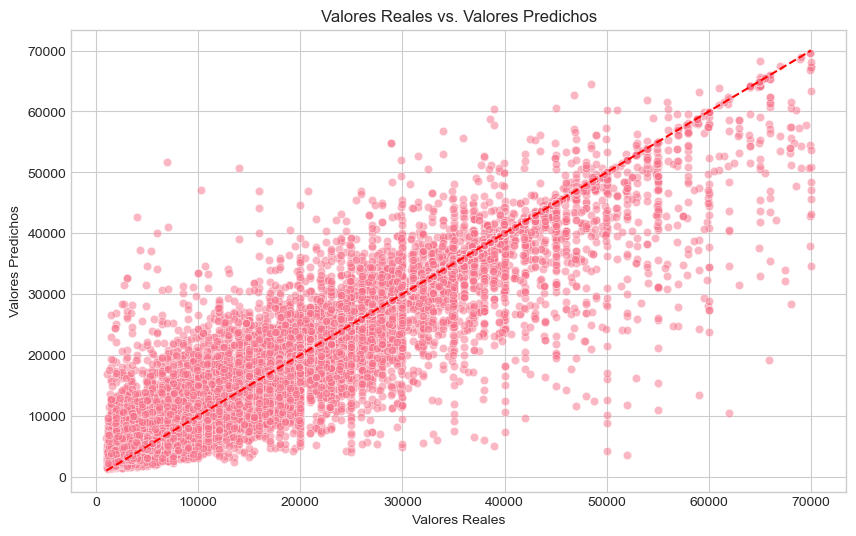

In [31]:

# Métricas para Random Forest Regressor
mae_rf = mean_absolute_error(y_test, y_pred_rf)
mse_rf = mean_squared_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf) 
print("Resultados en el conjunto de prueba - Random Forest Regressor:") 
print(f"Error Cuadrático Medio (MSE): {mse_rf:.2f}") 
print(f"Coeficiente de Determinación (R²): {r2_rf:.2f}") 
print(f"Error Absoluto Medio (MAE): {mae_rf:.2f}\n") 


plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_test, y=y_pred_rf, alpha=0.5)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--')
plt.xlabel('Valores Reales')
plt.ylabel('Valores Predichos')
plt.title('Valores Reales vs. Valores Predichos')
plt.show()


**Conclusión:**
El modelo Random Forest Regressor demuestra un rendimiento excelente en las predicciones, como se evidencia en el gráfico de dispersión y las métricas. La alta concordancia entre las predicciones y los valores reales, junto con métricas bajas de error y un alto R², sugieren que tu modelo es muy efectivo



 1. Optimización del Modelo:

- Optimizar el modelo seleccionado utilizando GridSearchCV.



 6. Documentación y Entrega:

- Documentar todo el proceso en un archivo .ipynb claramente comentado.
- Crear visualizaciones con interpretaciones.
- Subir el archivo a un repositorio en GitHub con un tag de liberación.
